# Load the features and initialize the constants

In [530]:
#%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as kb
#from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split


from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, concatenate, LSTM
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

import pydot, graphviz
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

# Visual Features

In [619]:
# ---------------------------------------
# Read feature names
# ---------------------------------------

f = open("../../openface_feature_names.json", "r")
all_features = json.load(f)
f.close()

#Regex to link feature names to what they represent
feature_regex = {
    "action_units": ['AU'],
    "gaze": ['gaze'],
    "shape": ['p_'],
    "landmarks_2d": [' x_', ' y_'],
    "landmarks_3d": [' X_', ' Y_', ' Z_'],
    "eye_lmk_2d": ["lmk_x", "lmk_y"],
    "eye_lmk_3d": ["lmk_X", "lmk_Y", "lmk_Z"],
    "output": ["rating"]
}
features = defaultdict(list)
for feature, regexes in feature_regex.items():
    for col in all_features:
        for regex in regexes:
            if regex in col:
                features[feature].append(col)

#Features to use for training
training_features = ['gaze', 'landmarks_2d', 'eye_lmk_2d', 'shape']
training_features = [ftr_name for feature in training_features for ftr_name in features[feature]]

df_vids = pd.read_csv("../../openface_features.csv", usecols=training_features)

feature_indices = sorted([all_features.index(feature) for feature in training_features])

#Constants
FEATURE_INDICES = feature_indices
MAX_FRAMES_PER_VIDEO = 600 #Pad/Truncate data to maitain 800 frames
FEATURE_COUNT = len(FEATURE_INDICES)
print("Number of features used for training : ", FEATURE_COUNT)

Number of features used for training :  296


# Text

In [471]:
GLOVE_DIR = '/Users/prabhjotsingh/Downloads/glove.twitter.27B'
EMBEDDING_DIM = 200

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1193514 word vectors.


In [500]:
#Constants
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1500

In [554]:
word_index = np.load('../../word_index.npy', allow_pickle=True)
word_index = word_index.item()
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Deep Learning

In [610]:
#Generator to load data in batches to avoid memory overflow

#Features and labels can be processed inside this generator
def gen(ftr_files):
    ftr_files = [file.decode() for file in ftr_files]
    #text_data = fxn() {video_id: input_features}
    ignored_files = list()
    
    for i, file in enumerate(ftr_files):
        #print(i, file)
        #Ignore hidden files such as '.dstore'
        if '.npy' not in file:
            continue
        try: #If any issues with reading the current file or missing label, ignore the video
            v_id = file.split('.')[0]
            label = np.load(f'../../visual_labels/{file}')
            
            #Visual Features
            ftrs = np.load(f'../../visual_features_scaled/{file}')
            visual_ftrs = ftrs[:, FEATURE_INDICES]
            
            #Text Features
            txt_ftrs = np.load(f'../../text_data/{file}')
            
        except Exception as e:
            ignored_files.append(v_id)#print(e)
            continue
        
        #Pad 0 valued frames(at the end) if frame count for the video lower than MAX_FRAMES_PER_VIDEO
        #Delete frames(from the front) if frame count grater than MAX_FRAMES_PER_VIDEO
        visual_ftrs = tf.keras.preprocessing.sequence.pad_sequences([visual_ftrs], maxlen=MAX_FRAMES_PER_VIDEO, 
                                                             dtype='float64', padding='post', 
                                                               truncating='pre', value=0.0)
        
        label = max(label, 0.001)
        #print(label)
        
        #print("Text frts shape", txt_ftrs.shape)
        yield {"input1":visual_ftrs[0], 'input2':txt_ftrs}, label
        
    #print(ignored_files)

In [598]:
#Generate an LSTM
def generate_model(input_size, max_length):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape = (input_size, max_length), name="input1"))
    
    rnn_layer = tf.keras.layers.LSTM(units = 50, activation = 'sigmoid', dropout = 0, recurrent_dropout = 0, implementation = 1, return_sequences = False)
    model.add(rnn_layer)
    
    dense_layer = tf.keras.layers.Dense(30)
    model.add(dense_layer)
    
    dense_layer = tf.keras.layers.Dense(1)
    model.add(dense_layer)
    
    model.compile(loss = 'mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2))
    #model.compile(loss=custom_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)) 
    model.build()
    model.summary()
    return model

def custom_loss(y_actual,y_pred):
    #custom_loss=100*(kb.abs((y_actual-kb.abs(y_pred)))/y_actual)
    #print(tf.executing_eagerly())
    #print(tf.math.equal(kb.abs(y_pred), y_pred))
    #x = tf.math.less(y_pred, kb.abs(y_pred))
    #if :
    custom_loss = tf.math.maximum(100.0, -1*(tf.math.sign(y_pred)*500))*(kb.abs((y_actual-kb.abs(y_pred)))/y_actual)
    return custom_loss#tf.math.max(custom_loss, custom_loss_2)

In [611]:
#Create the train and test datasets
#ftr_files = [file for file in os.listdir('../../visual_features/') if '.npy' in file]
def get_train_test_files():
    ftr_files = [file for file in os.listdir('../../visual_labels/') if '.npy' in file]
    np.random.shuffle(ftr_files)
    
    ratings = dict()        
    for file in ftr_files:
        video_id = file.split('.npy')[0]
        ratings[video_id] = [np.load(f'../../visual_labels/{file}')]
    
    bins=10
    files_per_bin = 100
    df_labels = pd.DataFrame.from_dict(ratings, orient='index', columns=['ratings'])
    #print(df_labels.columns, df_labels.index)
    #print(df_labels.groupby(pd.cut(df_labels['ratings'], bins=bins)).size())
    
    grps = df_labels.groupby(pd.cut(df_labels['ratings'], bins=bins))
    binned_files = [None for _ in range(bins)]
    for i, grp in enumerate(grps):
        video_id, _df = grp
        binned_files[i] = [file+".npy" for file in _df.index.values]
    
    #print(binned_files)
    #print(df_labels[df_labels['ratings']<0])
    
    #Keep x% of data as training
    train_size = 80 #In %age
    train, test = list(), list()
    for files in binned_files:
        files = files[:files_per_bin]
        file_count = len(files)
        split_index = (file_count*80)//100
        
        train += list(files[:split_index])
        test += list(files[split_index:])
    
    return train, test

train, test = get_train_test_files()

# f = open("video_ids_unbalanced.json", "w")
# json.dump(train+test, f)
# f.close()
# print(len(train+test))

print(len(train), len(test))
dataset_train = tf.data.Dataset.from_generator(
                         gen, output_types=({'input1':tf.float64, 'input2':tf.float64}, tf.float64),
                         output_shapes=(
                                         {'input1': tf.TensorShape((None, None)), 
                                         'input2': tf.TensorShape((1500))}, 
                                        tf.TensorShape(())
                                       ),
                        args=(train,))
dataset_train_batched = dataset_train.batch(32, drop_remainder=True)
#dataset_train_batched_prefetched = dataset_train_batched.prefetch(1)

#Test dataset
dataset_test = tf.data.Dataset.from_generator(
                            gen, output_types=({'input1':tf.float64,'input2':tf.float64}, tf.float64),
                            output_shapes=(
                                             {'input1': tf.TensorShape((None, None)), 
                                             'input2': tf.TensorShape((1500))}, 
                                            tf.TensorShape(())
                                           ),
                            args=(test,))
dataset_test_batched = dataset_test.batch(30, drop_remainder=True)
#dataset_test_prefetched = dataset_test_batched.prefetch(1)

768 193


In [612]:
#Visual
#model = generate_model(MAX_FRAMES_PER_VIDEO, FEATURE_COUNT)

#Text
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="input2")
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1.e-12, l2=1.e-12))(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(100, activation='relu')(x)

#Multimodal
visual_input = Input(shape=(MAX_FRAMES_PER_VIDEO, FEATURE_COUNT), name="input1")
secondary_layer = LSTM(100, return_sequences=False)(visual_input)
dense_visual = Dense(100)(secondary_layer)

In [613]:
merged_layers = concatenate([x, dense_visual])
preds = Dense(1, activation='linear')(merged_layers)

model = Model([sequence_input, visual_input], preds)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

print(model.summary())
plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1500, 200)    24280600    input2[0][0]                     
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 1496, 128)    128128      embedding_23[0][0]               
__________________________________________________________________________________________________
max_pooling1d_69 (MaxPooling1D) (None, 299, 128)     0           conv1d_69[0][0]                  
___________________________________________________________________________________________

In [614]:
history = model.fit(dataset_train_batched, epochs=25, validation_data=dataset_test_batched)
#history = model.fit(dataset_train, epochs=10, validation_data=dataset_test)
#history = model.fit()

Epoch 1/25
23/23 [==============================] - 24s 1s/step - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.2409 - val_root_mean_squared_error: 0.4908
Epoch 2/25
23/23 [==============================] - 29s 1s/step - loss: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.1699 - val_root_mean_squared_error: 0.4122
Epoch 3/25
23/23 [==============================] - 20s 858ms/step - loss: 0.1310 - root_mean_squared_error: 0.3620 - val_loss: 0.0653 - val_root_mean_squared_error: 0.2556
Epoch 4/25
23/23 [==============================] - 20s 879ms/step - loss: 0.0868 - root_mean_squared_error: 0.2947 - val_loss: 0.0676 - val_root_mean_squared_error: 0.2601
Epoch 5/25
23/23 [==============================] - 20s 863ms/step - loss: 0.0903 - root_mean_squared_error: 0.3005 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2553
Epoch 6/25
23/23 [==============================] - 19s 839ms/step - loss: 0.0833 - root_mean_squared_error: 0.2886 - val_loss: 0.0659 - val_

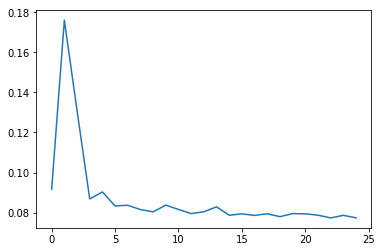

In [615]:
plt.plot(history.history['loss'])

(180,) (180,)


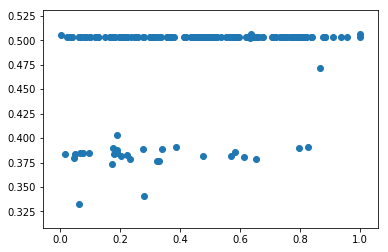

In [617]:
x_test_visual = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[0]['input1']])
x_test_txt = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[0]['input2']])

y_test = np.array([ele for batch in dataset_test_batched.as_numpy_iterator() for ele in batch[1]])
results = model.predict({"input1":x_test_visual, "input2":x_test_txt})
results = results.reshape(-1)
print(results.shape,y_test.shape)
plt.scatter(y_test, results)

In [264]:
#print(results, y_test)

In [265]:
tf.keras.losses.MSE(y_test, results)

<tf.Tensor: shape=(), dtype=float32, numpy=0.15468521>

In [266]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [267]:
import matplotlib.pyplot as plt

plt.scatter(y_test, c='b')
plt.scatter(inputs, results, c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

NameError: name 'inputs' is not defined